In [148]:
import pystan
import bebi103
import numpy as np
import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()
import matplotlib.pyplot as plt
import scipy.io
import multiprocessing
import scipy.stats as sts

light = '#eff3ff'
light_highlight = '#c6dbef'
mid = '#9ecae1'
mid_highlight = '#6baed6'
dark = '#3182bd'
dark_highlight = '#08519c'


%matplotlib inline

Loading BokehJS ...

In [21]:
sm_beta = pystan.StanModel(file='rvk_model_beta_full.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1c8abca283042f88b94c57a7b50fd23b NOW.


In [22]:
# Generate data using prior for prior-predictive check
sm_sim = pystan.StanModel(file='rvk_model_sim_full.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9379773b5f49e7db85692e5c09fcd379 NOW.


In [23]:
# Generate quantities from prior
R = 1000 # 100 trials
N = 60 #time steps

sim_data = sm_sim.sampling(data={'N': N},
                     iter=R, warmup=0, chains=1, refresh=R,
                     seed=4838284, algorithm="Fixed_param")

<IPython.core.display.Javascript object>


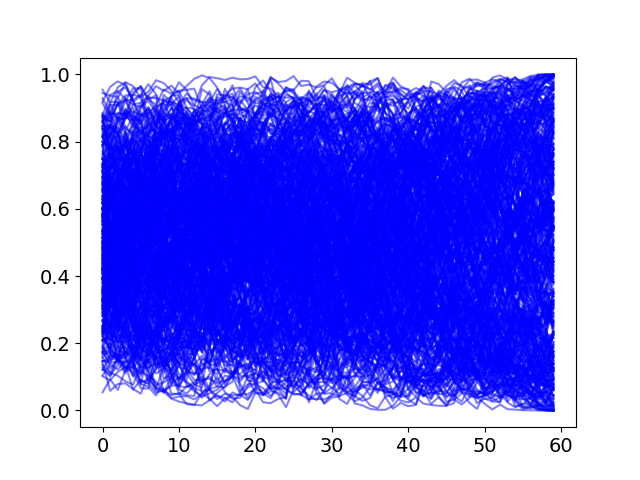

In [43]:
plt.figure()
plt.plot(sim_data['r'].T, 'b', alpha=0.5);

In [37]:
nantrials = np.isnan(sim_data['r'][:,0])

ysim = sim_data['y'][~nantrials,:]
rsim = sim_data['r'][~nantrials,:]
vsim = sim_data['v'][~nantrials,:]
ksim = sim_data['k'][~nantrials]
print(len(ysim))

437


In [68]:
fit = sm_beta.sampling(data=dict(N=N, y=ysim[0].astype('int')), seed=4938483, warmup=500, iter=1000, chains=4)

In [50]:
fit.summary(pars='k')['summary'][0,8]

4983.7237380848355

In [58]:
fit.to_dataframe()['warmup'].unique()

array([0], dtype=int64)

In [52]:
fit['k'].shape

(4000,)

In [97]:
comparison = fit.extract()['v'] > vsim[0]

In [96]:
fit.extract()['v'][:,0] > vsim[0]

ValueError: operands could not be broadcast together with shapes (2000,) (60,) 

In [88]:
fit.extract()['v'][:,1].shape

(2000,)

In [91]:
vsim[0]

array([-4.02883351, -4.01899959, -4.00831953, -4.02663904, -4.0434654 ,
       -4.05112668, -4.02157173, -4.01207624, -4.02355249, -4.02681721,
       -4.03600671, -4.01289197, -4.02584221, -3.9864925 , -3.97520565,
       -3.96145185, -3.97297315, -3.98139254, -3.96540063, -3.98954905,
       -3.98721008, -3.96265443, -3.9418311 , -3.9324738 , -3.91725345,
       -3.91926635, -3.92541045, -3.9245367 , -3.92768237, -3.93995319,
       -3.95086115, -3.93195548, -3.94758749, -3.93839895, -3.94311766,
       -3.93866983, -3.94508822, -3.94495794, -3.9470331 , -3.92901058,
       -3.92366702, -3.95037399, -3.95087881, -3.97281775, -3.95531718,
       -3.96171416, -3.95119856, -3.88392801, -3.90642916, -3.92676704,
       -3.93431218, -3.91465576, -3.92025081, -3.93896869, -3.89824545,
       -3.89170661, -3.87544173, -3.86723332, -3.89013913, -3.85544119])

In [98]:
np.sum(comparison, axis=0)

array([1195, 1104, 1034, 1171, 1285, 1321, 1110, 1069, 1144, 1149, 1215,
       1040, 1150,  863,  789,  699,  773,  845,  743,  876,  867,  723,
        606,  554,  489,  499,  549,  540,  540,  603,  672,  587,  639,
        610,  621,  597,  633,  635,  623,  561,  542,  664,  655,  776,
        667,  707,  665,  419,  488,  561,  597,  518,  526,  610,  465,
        454,  399,  381,  461,  345])

In [30]:
# Find the posterior for each simulation
def analyze_simu(simu):
    simu_y = simu[0].astype('int')
    simu_v = simu[1]
    input_data=dict(N=N, y=simu_y)
    fit = sm_beta.sampling(data=input_data, seed=4938483, warmup=500, iter=1000, chains=4)
    warning_code = bebi103.stan.check_all_diagnostics(fit, quiet=True)
    print(warning_code)
    # Extract the v values
    vvals = fit['v']
    sbc_rank = np.sum(vvals > simu_v)
    
    # Compute posterior sensitivities
    summary = fit.summary(pars='v', probs=[0.5])
    post_mean_v = summary['summary'][0, 0]
    post_sd_v = summary['summary'][0, 2]
    
    prior_sd_v = 0.1
    
    z_score = (post_mean_v - simu_v) / post_sd_v
    shrinkage = 1 - (post_sd_v / prior_sd_v)**2
    
    return [warning_code, sbc_rank, z_score, shrinkage]

In [102]:
# Find the posterior for each simulation, for the full model
def analyze_simu_full(simu):
    simu_y = simu[0].astype('int')
    simu_k = simu[1]
    simu_v = simu[2]
    simu_r = simu[3]
    
    input_data=dict(N=N, y=simu_y)
    fit = sm_beta.sampling(data=input_data, seed=4938483, warmup=500, iter=1000, chains=4)
    warning_code = bebi103.stan.check_all_diagnostics(fit, quiet=True)
    print(warning_code)
    
    # Statistics of the k values, thinned by factor of 8
    kvals = fit.extract()['k']#[np.arange(0, 2000 - 7, 8)]
    sbc_rank_k = np.sum(kvals > simu_k)
    
    # Statistics of the v values
    comparison_v = fit.extract()['v'] > simu_v
    sbc_rank_v = np.sum(comparison_v, axis=0)
    
    # Statistics of the r values
    comparison_r = fit.extract()['r'] > simu_r
    sbc_rank_r = np.sum(comparison_r, axis=0)
    
    return [warning_code, sbc_rank_k, sbc_rank_v, sbc_rank_r]

In [32]:
simu_y = ysim[0].astype('int')
simu_v = vsim[0]
input_data=dict(N=N, y=simu_y)
fit = sm_beta.sampling(data=input_data, seed=4938483, warmup=500, iter=1000, chains=4)

In [34]:
codes = []
ranks = []
zscores = []
shrinks = []
for i in range(len(ysim)):
    print('Working on iteration', i)
    code, rank, zscore, shrink = analyze_simu([ysim[i], vsim[i]])
    codes.append(code)
    ranks.append(rank)
    zscores.append(zscores)
    shrinks.append(shrink)
    

Working on iteration 0
0
Working on iteration 1
0
Working on iteration 2
0
Working on iteration 3
0
Working on iteration 4
0
Working on iteration 5
0
Working on iteration 6
0
Working on iteration 7
0
Working on iteration 8
0
Working on iteration 9
0
Working on iteration 10
0
Working on iteration 11
0
Working on iteration 12


8
Working on iteration 13


8
Working on iteration 14
0
Working on iteration 15
0
Working on iteration 16
0
Working on iteration 17
0
Working on iteration 18
0
Working on iteration 19


8
Working on iteration 20
0
Working on iteration 21
0
Working on iteration 22
0
Working on iteration 23
0
Working on iteration 24
0
Working on iteration 25
0
Working on iteration 26
0
Working on iteration 27
0
Working on iteration 28
0
Working on iteration 29
0
Working on iteration 30
0
Working on iteration 31
0
Working on iteration 32
0
Working on iteration 33
0
Working on iteration 34
0
Working on iteration 35
0
Working on iteration 36
0
Working on iteration 37
0
Working on iteration 38
0
Working on iteration 39
0
Working on iteration 40
0
Working on iteration 41
0
Working on iteration 42
0
Working on iteration 43
0
Working on iteration 44
0
Working on iteration 45
0
Working on iteration 46
0
Working on iteration 47
0
Working on iteration 48
0
Working on iteration 49
0
Working on iteration 50


8
Working on iteration 51
0
Working on iteration 52
0
Working on iteration 53
0
Working on iteration 54
0
Working on iteration 55
0
Working on iteration 56
0
Working on iteration 57
0
Working on iteration 58
0
Working on iteration 59
0
Working on iteration 60


8
Working on iteration 61
0
Working on iteration 62
0
Working on iteration 63
0
Working on iteration 64
0
Working on iteration 65
0
Working on iteration 66
0
Working on iteration 67
0
Working on iteration 68
0
Working on iteration 69
0
Working on iteration 70
0
Working on iteration 71
0
Working on iteration 72
0
Working on iteration 73
0
Working on iteration 74


8
Working on iteration 75
0
Working on iteration 76


8
Working on iteration 77
0
Working on iteration 78
0
Working on iteration 79
0
Working on iteration 80
0
Working on iteration 81
0
Working on iteration 82


8
Working on iteration 83
0
Working on iteration 84
0
Working on iteration 85
0
Working on iteration 86
0
Working on iteration 87
0
Working on iteration 88
0
Working on iteration 89
0
Working on iteration 90
0
Working on iteration 91
0
Working on iteration 92
0
Working on iteration 93
0
Working on iteration 94
0
Working on iteration 95
0
Working on iteration 96
0
Working on iteration 97


8
Working on iteration 98
0
Working on iteration 99
0
Working on iteration 100
0
Working on iteration 101
0
Working on iteration 102
0
Working on iteration 103
0
Working on iteration 104
0
Working on iteration 105
0
Working on iteration 106
0
Working on iteration 107
0
Working on iteration 108
0
Working on iteration 109
0
Working on iteration 110
0
Working on iteration 111
0
Working on iteration 112
0
Working on iteration 113
0
Working on iteration 114
0
Working on iteration 115
0
Working on iteration 116
0
Working on iteration 117
0
Working on iteration 118
0
Working on iteration 119
0
Working on iteration 120
0
Working on iteration 121
0
Working on iteration 122
0
Working on iteration 123
0
Working on iteration 124
0
Working on iteration 125
0
Working on iteration 126
0
Working on iteration 127
0
Working on iteration 128
0
Working on iteration 129
0
Working on iteration 130
0
Working on iteration 131
0
Working on iteration 132
0
Working on iteration 133
0
Working on iteration 134
0
W

8
Working on iteration 136
0
Working on iteration 137
0
Working on iteration 138
0
Working on iteration 139
0
Working on iteration 140
0
Working on iteration 141
0
Working on iteration 142
0
Working on iteration 143
0
Working on iteration 144
0
Working on iteration 145
0
Working on iteration 146
0
Working on iteration 147
0
Working on iteration 148
0
Working on iteration 149
0
Working on iteration 150
0
Working on iteration 151
0
Working on iteration 152
0
Working on iteration 153
0
Working on iteration 154
0
Working on iteration 155
0
Working on iteration 156
0
Working on iteration 157
0
Working on iteration 158
0
Working on iteration 159
0
Working on iteration 160
0
Working on iteration 161
0
Working on iteration 162
0
Working on iteration 163
0
Working on iteration 164
0
Working on iteration 165
0
Working on iteration 166
0
Working on iteration 167
0
Working on iteration 168
0
Working on iteration 169
0
Working on iteration 170
0
Working on iteration 171
0
Working on iteration 172
0

8
Working on iteration 174
0
Working on iteration 175
0
Working on iteration 176
0
Working on iteration 177
0
Working on iteration 178
0
Working on iteration 179
0
Working on iteration 180
0
Working on iteration 181
0
Working on iteration 182


8
Working on iteration 183


8
Working on iteration 184
0
Working on iteration 185


8
Working on iteration 186
0
Working on iteration 187
0
Working on iteration 188
0
Working on iteration 189
0
Working on iteration 190
0
Working on iteration 191
0
Working on iteration 192
0
Working on iteration 193
0
Working on iteration 194
0
Working on iteration 195
0
Working on iteration 196


8
Working on iteration 197
0
Working on iteration 198
0
Working on iteration 199


8
Working on iteration 200


8
Working on iteration 201
0
Working on iteration 202
0
Working on iteration 203
0
Working on iteration 204
0
Working on iteration 205
0
Working on iteration 206
0
Working on iteration 207
0
Working on iteration 208


8
Working on iteration 209


8
Working on iteration 210
0
Working on iteration 211


8
Working on iteration 212


8
Working on iteration 213
0
Working on iteration 214


8
Working on iteration 215
0
Working on iteration 216
0
Working on iteration 217
0
Working on iteration 218
0
Working on iteration 219
0
Working on iteration 220
0
Working on iteration 221
0
Working on iteration 222
0
Working on iteration 223
0
Working on iteration 224


8
Working on iteration 225
0
Working on iteration 226
0
Working on iteration 227
0
Working on iteration 228
0
Working on iteration 229
0
Working on iteration 230
0
Working on iteration 231
0
Working on iteration 232
0
Working on iteration 233
0
Working on iteration 234
0
Working on iteration 235
0
Working on iteration 236
0
Working on iteration 237
0
Working on iteration 238
0
Working on iteration 239
0
Working on iteration 240
0
Working on iteration 241
0
Working on iteration 242
0
Working on iteration 243


8
Working on iteration 244
0
Working on iteration 245
0
Working on iteration 246
0
Working on iteration 247
0
Working on iteration 248
0
Working on iteration 249
0
Working on iteration 250
0
Working on iteration 251
0
Working on iteration 252
0
Working on iteration 253
0
Working on iteration 254
0
Working on iteration 255
0
Working on iteration 256
0
Working on iteration 257
0
Working on iteration 258
0
Working on iteration 259
0
Working on iteration 260
0
Working on iteration 261
0
Working on iteration 262
0
Working on iteration 263
0
Working on iteration 264
0
Working on iteration 265
0
Working on iteration 266
0
Working on iteration 267
0
Working on iteration 268


8
Working on iteration 269
0
Working on iteration 270
0
Working on iteration 271
0
Working on iteration 272
0
Working on iteration 273


8
Working on iteration 274
0
Working on iteration 275
0
Working on iteration 276
0
Working on iteration 277
0
Working on iteration 278
0
Working on iteration 279
0
Working on iteration 280
0
Working on iteration 281


8
Working on iteration 282
0
Working on iteration 283
0
Working on iteration 284
0
Working on iteration 285
0
Working on iteration 286
0
Working on iteration 287
0
Working on iteration 288
0
Working on iteration 289
0
Working on iteration 290


8
Working on iteration 291
0
Working on iteration 292
0
Working on iteration 293
0
Working on iteration 294
0
Working on iteration 295
0
Working on iteration 296
0
Working on iteration 297
0
Working on iteration 298
0
Working on iteration 299
0
Working on iteration 300
0
Working on iteration 301
0
Working on iteration 302
0
Working on iteration 303
0
Working on iteration 304
0
Working on iteration 305
0
Working on iteration 306


8
Working on iteration 307
0
Working on iteration 308
0
Working on iteration 309
0
Working on iteration 310
0
Working on iteration 311
0
Working on iteration 312
0
Working on iteration 313
0
Working on iteration 314
0
Working on iteration 315
0
Working on iteration 316
0
Working on iteration 317
0
Working on iteration 318
0
Working on iteration 319


8
Working on iteration 320
0
Working on iteration 321
0
Working on iteration 322


8
Working on iteration 323
0
Working on iteration 324
0
Working on iteration 325
0
Working on iteration 326
0
Working on iteration 327


8
Working on iteration 328
0
Working on iteration 329
0
Working on iteration 330
0
Working on iteration 331
0
Working on iteration 332
0
Working on iteration 333
0
Working on iteration 334
0
Working on iteration 335
0
Working on iteration 336
0
Working on iteration 337
0
Working on iteration 338
0
Working on iteration 339


8
Working on iteration 340
0
Working on iteration 341
0
Working on iteration 342
0
Working on iteration 343
0
Working on iteration 344
0
Working on iteration 345
0
Working on iteration 346
0
Working on iteration 347
0
Working on iteration 348
0
Working on iteration 349
0
Working on iteration 350
0
Working on iteration 351
0
Working on iteration 352
0
Working on iteration 353
0
Working on iteration 354
0
Working on iteration 355
0
Working on iteration 356
0
Working on iteration 357


8
Working on iteration 358
0
Working on iteration 359
0
Working on iteration 360
0
Working on iteration 361
0
Working on iteration 362
0
Working on iteration 363
0
Working on iteration 364
0
Working on iteration 365
0
Working on iteration 366
0
Working on iteration 367
0
Working on iteration 368
0
Working on iteration 369
0
Working on iteration 370
0
Working on iteration 371


8
Working on iteration 372
0
Working on iteration 373
0
Working on iteration 374
0
Working on iteration 375
0
Working on iteration 376
0
Working on iteration 377
0
Working on iteration 378
0
Working on iteration 379
0
Working on iteration 380
0
Working on iteration 381
0
Working on iteration 382


8
Working on iteration 383
0
Working on iteration 384
0
Working on iteration 385
0
Working on iteration 386
0
Working on iteration 387
0
Working on iteration 388
0
Working on iteration 389
0
Working on iteration 390
0
Working on iteration 391
0
Working on iteration 392
0
Working on iteration 393
0
Working on iteration 394
0
Working on iteration 395


8
Working on iteration 396
0
Working on iteration 397
0
Working on iteration 398
0
Working on iteration 399
0
Working on iteration 400


8
Working on iteration 401
0
Working on iteration 402
0
Working on iteration 403
0
Working on iteration 404
0
Working on iteration 405
0
Working on iteration 406
0
Working on iteration 407
0
Working on iteration 408
0
Working on iteration 409
0
Working on iteration 410
0
Working on iteration 411
0
Working on iteration 412


8
Working on iteration 413


8
Working on iteration 414
0
Working on iteration 415


8
Working on iteration 416


8
Working on iteration 417
0
Working on iteration 418
0
Working on iteration 419
0
Working on iteration 420
0
Working on iteration 421
0
Working on iteration 422


8
Working on iteration 423
0
Working on iteration 424


8
Working on iteration 425
0
Working on iteration 426
0
Working on iteration 427
0
Working on iteration 428
0
Working on iteration 429


8
Working on iteration 430
0
Working on iteration 431
0
Working on iteration 432
0
Working on iteration 433
0
Working on iteration 434
0
Working on iteration 435
0
Working on iteration 436
0


In [ ]:
scipy.io.savemat('sbc_check_v_beta_441trials.mat', {'codes': codes, 'ranks': ranks, 'zscores': zscores,
                                                   'shrinks': shrinks, 'ysim': ysim, 'rsim': rsim, 'vsim': vsim})

<IPython.core.display.Javascript object>


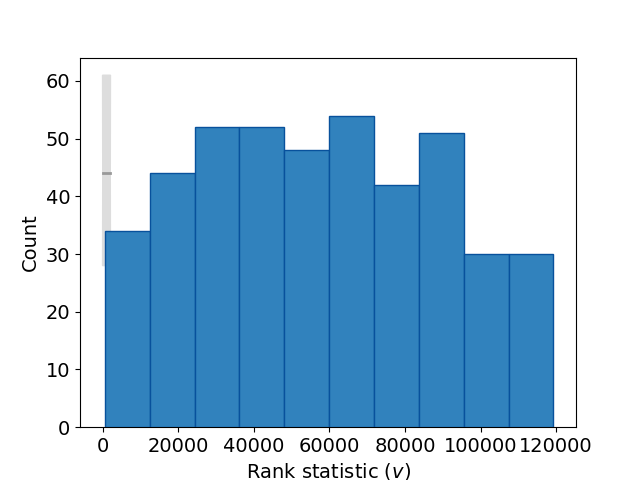

Text(0, 0.5, 'Count')

In [35]:
plt.figure()

font = {'size'   : 14}

plt.rc('font', **font)


R = len(ysim)
protruding = 50

sbc_low = sts.binom.ppf(0.005, R, 0.1)
sbc_mid = sts.binom.ppf(0.5, R, 0.1)
sbc_high = sts.binom.ppf(0.995, R, 0.1)

bar_x = [-protruding, 2000 + protruding, 2000, 2000 + protruding, -protruding, 0, -protruding]
bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

plt.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
plt.plot([0, 2000], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

plt.hist(ranks, ec=dark_highlight, color=dark, zorder=3)
plt.gca().set_xlabel("Rank statistic ($v$)")
#plt.gca().set_xlim(-protruding-20, 2000 + protruding+20)
plt.ylabel('Count')

#plt.savefig('sbc_results_beta_441trials.pdf')

In [27]:
bokeh.io.show(bebi103.viz.corner(fit, 
                                 pars=['k', 'v[1]', 'r[2]', 'r[3]', 'r[4]'],
                                 labels=['k', 'v[1]', 'r[2]', 'r[3]', 'r[4]']))

In [112]:
codes = []
ranks_k = []
ranks_v = []
ranks_r = []
for i in range(len(ysim)):
    print('Working on iteration', i)
    code, rank_k, rank_v, rank_r = analyze_simu_full([ysim[i], ksim[i], vsim[i], rsim[i]])
    codes.append(code)
    ranks_k.append(rank_k)
    ranks_v.append(rank_v)
    ranks_r.append(rank_r)
ranks_r = np.array(ranks_r)
ranks_v = np.array(ranks_v)

Working on iteration 0
0
Working on iteration 1
0
Working on iteration 2
0
Working on iteration 3
0
Working on iteration 4
0
Working on iteration 5
0
Working on iteration 6
0
Working on iteration 7
0
Working on iteration 8
0
Working on iteration 9
0
Working on iteration 10
0
Working on iteration 11
0
Working on iteration 12


8
Working on iteration 13


8
Working on iteration 14
0
Working on iteration 15
0
Working on iteration 16
0
Working on iteration 17
0
Working on iteration 18
0
Working on iteration 19


8
Working on iteration 20
0
Working on iteration 21
0
Working on iteration 22
0
Working on iteration 23
0
Working on iteration 24
0
Working on iteration 25
0
Working on iteration 26
0
Working on iteration 27
0
Working on iteration 28
0
Working on iteration 29
0
Working on iteration 30
0
Working on iteration 31
0
Working on iteration 32
0
Working on iteration 33
0
Working on iteration 34
0
Working on iteration 35
0
Working on iteration 36
0
Working on iteration 37
0
Working on iteration 38
0
Working on iteration 39
0
Working on iteration 40
0
Working on iteration 41
0
Working on iteration 42
0
Working on iteration 43
0
Working on iteration 44
0
Working on iteration 45
0
Working on iteration 46
0
Working on iteration 47
0
Working on iteration 48
0
Working on iteration 49
0
Working on iteration 50


8
Working on iteration 51
0
Working on iteration 52
0
Working on iteration 53
0
Working on iteration 54
0
Working on iteration 55
0
Working on iteration 56
0
Working on iteration 57
0
Working on iteration 58
0
Working on iteration 59
0
Working on iteration 60


8
Working on iteration 61
0
Working on iteration 62
0
Working on iteration 63
0
Working on iteration 64
0
Working on iteration 65
0
Working on iteration 66
0
Working on iteration 67
0
Working on iteration 68
0
Working on iteration 69
0
Working on iteration 70
0
Working on iteration 71
0
Working on iteration 72
0
Working on iteration 73
0
Working on iteration 74


8
Working on iteration 75
0
Working on iteration 76


8
Working on iteration 77
0
Working on iteration 78
0
Working on iteration 79
0
Working on iteration 80
0
Working on iteration 81
0
Working on iteration 82


8
Working on iteration 83
0
Working on iteration 84
0
Working on iteration 85
0
Working on iteration 86
0
Working on iteration 87
0
Working on iteration 88
0
Working on iteration 89
0
Working on iteration 90
0
Working on iteration 91
0
Working on iteration 92
0
Working on iteration 93
0
Working on iteration 94
0
Working on iteration 95
0
Working on iteration 96
0
Working on iteration 97


8
Working on iteration 98
0
Working on iteration 99
0
Working on iteration 100
0
Working on iteration 101
0
Working on iteration 102
0
Working on iteration 103
0
Working on iteration 104
0
Working on iteration 105
0
Working on iteration 106
0
Working on iteration 107
0
Working on iteration 108
0
Working on iteration 109
0
Working on iteration 110
0
Working on iteration 111
0
Working on iteration 112
0
Working on iteration 113
0
Working on iteration 114
0
Working on iteration 115
0
Working on iteration 116
0
Working on iteration 117
0
Working on iteration 118
0
Working on iteration 119
0
Working on iteration 120
0
Working on iteration 121
0
Working on iteration 122
0
Working on iteration 123
0
Working on iteration 124
0
Working on iteration 125
0
Working on iteration 126
0
Working on iteration 127
0
Working on iteration 128
0
Working on iteration 129
0
Working on iteration 130
0
Working on iteration 131
0
Working on iteration 132
0
Working on iteration 133
0
Working on iteration 134
0
W

8
Working on iteration 136
0
Working on iteration 137
0
Working on iteration 138
0
Working on iteration 139
0
Working on iteration 140
0
Working on iteration 141
0
Working on iteration 142
0
Working on iteration 143
0
Working on iteration 144
0
Working on iteration 145
0
Working on iteration 146
0
Working on iteration 147
0
Working on iteration 148
0
Working on iteration 149
0
Working on iteration 150
0
Working on iteration 151
0
Working on iteration 152
0
Working on iteration 153
0
Working on iteration 154
0
Working on iteration 155
0
Working on iteration 156
0
Working on iteration 157
0
Working on iteration 158
0
Working on iteration 159
0
Working on iteration 160
0
Working on iteration 161
0
Working on iteration 162
0
Working on iteration 163
0
Working on iteration 164
0
Working on iteration 165
0
Working on iteration 166
0
Working on iteration 167
0
Working on iteration 168
0
Working on iteration 169
0
Working on iteration 170
0
Working on iteration 171
0
Working on iteration 172
0

8
Working on iteration 174
0
Working on iteration 175
0
Working on iteration 176
0
Working on iteration 177
0
Working on iteration 178
0
Working on iteration 179
0
Working on iteration 180
0
Working on iteration 181
0
Working on iteration 182


8
Working on iteration 183


8
Working on iteration 184
0
Working on iteration 185


8
Working on iteration 186
0
Working on iteration 187
0
Working on iteration 188
0
Working on iteration 189
0
Working on iteration 190
0
Working on iteration 191
0
Working on iteration 192
0
Working on iteration 193
0
Working on iteration 194
0
Working on iteration 195
0
Working on iteration 196


8
Working on iteration 197
0
Working on iteration 198
0
Working on iteration 199


8
Working on iteration 200


8
Working on iteration 201
0
Working on iteration 202
0
Working on iteration 203
0
Working on iteration 204
0
Working on iteration 205
0
Working on iteration 206
0
Working on iteration 207
0
Working on iteration 208


8
Working on iteration 209


8
Working on iteration 210
0
Working on iteration 211


8
Working on iteration 212


8
Working on iteration 213
0
Working on iteration 214


8
Working on iteration 215
0
Working on iteration 216
0
Working on iteration 217
0
Working on iteration 218
0
Working on iteration 219
0
Working on iteration 220
0
Working on iteration 221
0
Working on iteration 222
0
Working on iteration 223
0
Working on iteration 224


8
Working on iteration 225
0
Working on iteration 226
0
Working on iteration 227
0
Working on iteration 228
0
Working on iteration 229
0
Working on iteration 230
0
Working on iteration 231
0
Working on iteration 232
0
Working on iteration 233
0
Working on iteration 234
0
Working on iteration 235
0
Working on iteration 236
0
Working on iteration 237
0
Working on iteration 238
0
Working on iteration 239
0
Working on iteration 240
0
Working on iteration 241
0
Working on iteration 242
0
Working on iteration 243


8
Working on iteration 244
0
Working on iteration 245
0
Working on iteration 246
0
Working on iteration 247
0
Working on iteration 248
0
Working on iteration 249
0
Working on iteration 250
0
Working on iteration 251
0
Working on iteration 252
0
Working on iteration 253
0
Working on iteration 254
0
Working on iteration 255
0
Working on iteration 256
0
Working on iteration 257
0
Working on iteration 258
0
Working on iteration 259
0
Working on iteration 260
0
Working on iteration 261
0
Working on iteration 262
0
Working on iteration 263
0
Working on iteration 264
0
Working on iteration 265
0
Working on iteration 266
0
Working on iteration 267
0
Working on iteration 268


8
Working on iteration 269
0
Working on iteration 270
0
Working on iteration 271
0
Working on iteration 272
0
Working on iteration 273


8
Working on iteration 274
0
Working on iteration 275
0
Working on iteration 276
0
Working on iteration 277
0
Working on iteration 278
0
Working on iteration 279
0
Working on iteration 280
0
Working on iteration 281


8
Working on iteration 282
0
Working on iteration 283
0
Working on iteration 284
0
Working on iteration 285
0
Working on iteration 286
0
Working on iteration 287
0
Working on iteration 288
0
Working on iteration 289
0
Working on iteration 290


8
Working on iteration 291
0
Working on iteration 292
0
Working on iteration 293
0
Working on iteration 294
0
Working on iteration 295
0
Working on iteration 296
0
Working on iteration 297
0
Working on iteration 298
0
Working on iteration 299
0
Working on iteration 300
0
Working on iteration 301
0
Working on iteration 302
0
Working on iteration 303
0
Working on iteration 304
0
Working on iteration 305
0
Working on iteration 306


8
Working on iteration 307
0
Working on iteration 308
0
Working on iteration 309
0
Working on iteration 310
0
Working on iteration 311
0
Working on iteration 312
0
Working on iteration 313
0
Working on iteration 314
0
Working on iteration 315
0
Working on iteration 316
0
Working on iteration 317
0
Working on iteration 318
0
Working on iteration 319


8
Working on iteration 320
0
Working on iteration 321
0
Working on iteration 322


8
Working on iteration 323
0
Working on iteration 324
0
Working on iteration 325
0
Working on iteration 326
0
Working on iteration 327


8
Working on iteration 328
0
Working on iteration 329
0
Working on iteration 330
0
Working on iteration 331
0
Working on iteration 332
0
Working on iteration 333
0
Working on iteration 334
0
Working on iteration 335
0
Working on iteration 336
0
Working on iteration 337
0
Working on iteration 338
0
Working on iteration 339


8
Working on iteration 340
0
Working on iteration 341
0
Working on iteration 342
0
Working on iteration 343
0
Working on iteration 344
0
Working on iteration 345
0
Working on iteration 346
0
Working on iteration 347
0
Working on iteration 348
0
Working on iteration 349
0
Working on iteration 350
0
Working on iteration 351
0
Working on iteration 352
0
Working on iteration 353
0
Working on iteration 354
0
Working on iteration 355
0
Working on iteration 356
0
Working on iteration 357


8
Working on iteration 358
0
Working on iteration 359
0
Working on iteration 360
0
Working on iteration 361
0
Working on iteration 362
0
Working on iteration 363
0
Working on iteration 364
0
Working on iteration 365
0
Working on iteration 366
0
Working on iteration 367
0
Working on iteration 368
0
Working on iteration 369
0
Working on iteration 370
0
Working on iteration 371


8
Working on iteration 372
0
Working on iteration 373
0
Working on iteration 374
0
Working on iteration 375
0
Working on iteration 376
0
Working on iteration 377
0
Working on iteration 378
0
Working on iteration 379
0
Working on iteration 380
0
Working on iteration 381
0
Working on iteration 382


8
Working on iteration 383
0
Working on iteration 384
0
Working on iteration 385
0
Working on iteration 386
0
Working on iteration 387
0
Working on iteration 388
0
Working on iteration 389
0
Working on iteration 390
0
Working on iteration 391
0
Working on iteration 392
0
Working on iteration 393
0
Working on iteration 394
0
Working on iteration 395


8
Working on iteration 396
0
Working on iteration 397
0
Working on iteration 398
0
Working on iteration 399
0
Working on iteration 400


8
Working on iteration 401
0
Working on iteration 402
0
Working on iteration 403
0
Working on iteration 404
0
Working on iteration 405
0
Working on iteration 406
0
Working on iteration 407
0
Working on iteration 408
0
Working on iteration 409
0
Working on iteration 410
0
Working on iteration 411
0
Working on iteration 412


8
Working on iteration 413


8
Working on iteration 414
0
Working on iteration 415


8
Working on iteration 416


8
Working on iteration 417
0
Working on iteration 418
0
Working on iteration 419
0
Working on iteration 420
0
Working on iteration 421
0
Working on iteration 422


8
Working on iteration 423
0
Working on iteration 424


8
Working on iteration 425
0
Working on iteration 426
0
Working on iteration 427
0
Working on iteration 428
0
Working on iteration 429


8
Working on iteration 430
0
Working on iteration 431
0
Working on iteration 432
0
Working on iteration 433
0
Working on iteration 434
0
Working on iteration 435
0
Working on iteration 436
0


In [126]:
scipy.io.savemat('sbc_full_437trials_beta.mat', dict(ranks_k=ranks_k, ranks_r=ranks_r, ranks_v=ranks_v,
                                                    codes=codes, ysim=ysim, vsim=vsim, rsim=rsim, ksim=ksim))

In [163]:
def plot_sbc(array, R, nbins, nsamples, title):
    protruding = 50

    sbc_low = sts.binom.ppf(0.005, R, 1.0 / nbins)
    sbc_mid = sts.binom.ppf(0.5, R, 1.0 / nbins)
    sbc_high = sts.binom.ppf(0.995, R, 1.0 / nbins)

    bar_x = [-protruding, nsamples + protruding, nsamples, nsamples + protruding, -protruding, 0, -protruding]
    bar_y = [sbc_high, sbc_high, sbc_mid, sbc_low, sbc_low, sbc_mid, sbc_high]

    plt.fill(bar_x, bar_y, color="#DDDDDD", ec="#DDDDDD")
    plt.plot([0, nsamples], [sbc_mid, sbc_mid], color="#999999", linewidth=2)

    plt.hist(array, ec=dark_highlight, color=dark, zorder=3, bins=nbins)
    plt.gca().set_xlabel(title)
    plt.ylabel('Count')

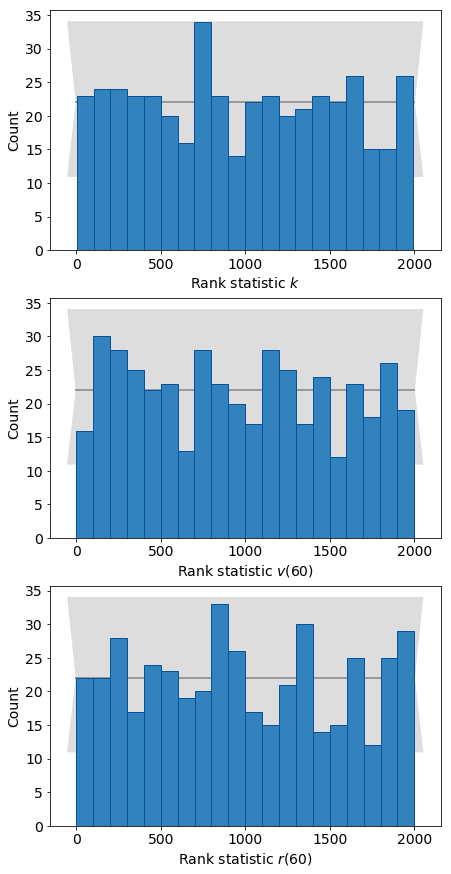

In [165]:
R = len(ysim)
plt.figure(figsize=(7,15))
plt.subplot(311)
plot_sbc(ranks_k, R, 20, 2000, "Rank statistic $k$")

plt.subplot(312)
plot_sbc(ranks_v[:,59], R, 20, 2000, "Rank statistic $v(60)$")

plt.subplot(313)
plot_sbc(ranks_r[:,59], R, 20, 2000, "Rank statistic $r(60)$")